In [22]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening BSCCM
Opened BSCCM


In [23]:
experiment_dir = '/home/hpinkard_waller/models/Synthetic_Noise_v4/'

mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
phenotype_nlls = {}
phenotype_marker_indices = {}
for dir_name in os.listdir(experiment_dir):
    if 'Analysis' in dir_name:
        config_file_name = [d for d in os.listdir(os.path.join(experiment_dir, dir_name)) if '.yaml' in d][0]
        config_file_full_path = os.path.join(experiment_dir, dir_name, config_file_name)
        config = yaml.load(open(config_file_full_path, 'r'), Loader=yaml.FullLoader)
        photons_per_pixel = config['data']['synthetic_noise']['photons_per_pixel']
        channel = config['data']['channels'][0]
        replicate = config['metadata']['replicate']
        saving_dir = os.path.join(experiment_dir, dir_name)
        analysis_dir = os.path.join(saving_dir, 'analysis')
        mi_estimate_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'mi_estimates' in f][0]))
        mi_estimates_gp[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_gp']

        # print the channel, photons and mi_gp
        print(channel, photons_per_pixel, mi_estimates_gp[(channel, photons_per_pixel, replicate)])

        mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_pixel_cnn']
        nll_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'phenotyping_nll' in f][0]))
        phenotype_nlls[(channel, photons_per_pixel, replicate)] = nll_file['nlls']
        phenotype_marker_indices[(channel, photons_per_pixel, replicate)] = nll_file['marker_indices']
    

Brightfield 100 0.0067025289114603995
DPC_Right 200 0.18682976686783798
LED119 100 0.1737961598447649
DPC_Right 100 0.15349971802799633
Brightfield 50 0.01649572142894274
LED119 50 0.21715179876290358
LED119 200 -0.06727053724992393
Brightfield 200 -0.007740177124709098
DPC_Right 50 0.12765267719660095


In [24]:
markers, _, _, _, _ = get_targets_and_display_range(bsccm=bsccm, use_two_spectrum_unmixing=True)
markers

['CD45', 'CD123', 'CD19', 'CD56', 'CD14', 'CD16', 'HLA-DR', 'CD3']

Channel: LED119, photons per pixel: 50, MI: 0.15, NLL: 0.10
Channel: LED119, photons per pixel: 100, MI: 0.11, NLL: 0.00
Channel: LED119, photons per pixel: 200, MI: -0.18, NLL: 0.05


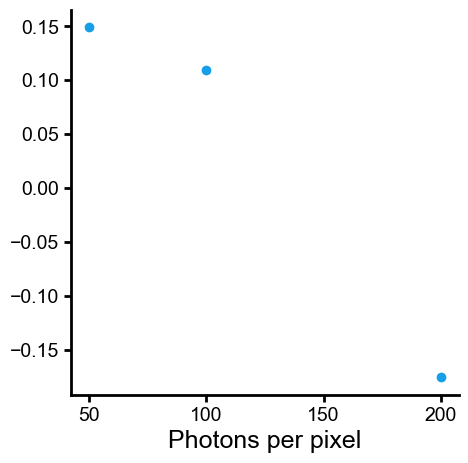

In [25]:
photons_per_pixel = 50

mis = []
nlls = []
# for channel in ['DPC_Right', 'Brightfield', 'LED119']:
channel = 'LED119'
photons_per_pixel_list = [50, 100, 200]
for photons_per_pixel in photons_per_pixel_list:
    test_set_nlls = np.array(phenotype_nlls[(channel, photons_per_pixel, 0)])
    marker_indices = phenotype_marker_indices[(channel, photons_per_pixel, 0)]
    nll = test_set_nlls.mean()
    mi = mi_estimates_pixel_cnn[(channel, photons_per_pixel, 0)]
    mis.append(mi)
    nlls.append(nll)
    # print with nice formatting
    print(f'Channel: {channel}, photons per pixel: {photons_per_pixel}, MI: {mi:.2f}, NLL: {nll:.2f}')

# plot phenotype nll vs mi pixel cnn for 200 photons per pixel
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(photons_per_pixel_list, mis, 'o')
ax.set_xlabel('Photons per pixel')
clear_spines(ax)

In [28]:
num_images = 1000
num_patches = 1000
patch_size = 30

def estimate_gp_mi(config):
    median_filter = True

    markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **config['data'])
    images = load_bsccm_images(bsccm, indices=indices[:num_images], channel=config['data']['channels'][0], 
                convert_units_to_photons=True, edge_crop=config['data']['synthetic_noise']['edge_crop'],
                median_filter=median_filter, verbose=True)

    mean_photons_per_pixel = np.mean(images)
    rescale_fraction = config['data']['synthetic_noise']['photons_per_pixel'] / mean_photons_per_pixel
    if rescale_fraction > 1:
        raise Exception('Rescale fraction must be less than 1')

    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=True)

    if median_filter:
        # assume noiseless
        noisy_patches = add_noise(patches * rescale_fraction)
    else:
        noisy_patches = add_shot_noise_to_experimenal_data(patches, rescale_fraction)
    clean_patches = patches * rescale_fraction

    print('mean pixel_val', np.mean(clean_patches), np.mean(noisy_patches))

    mi =  estimate_mutual_information(noisy_patches, clean_images=clean_patches if median_filter else None,
                        entropy_model='gaussian', max_epochs=10,
                        verbose=True)
    return mi




In [30]:
mis = []

for photons_per_pixel in [50, 100, 200]:
    channel = 'DPC_Right'
    experiment_name = 'Synthetic_Noise_v4_{}_{}photons_replicate_0'.format(channel, photons_per_pixel)
    config_file_full_path = os.path.join(experiment_dir, experiment_name, experiment_name + '.yaml')
    config = yaml.load(open(config_file_full_path, 'r'), Loader=yaml.FullLoader)
    break
    mis.append(estimate_gp_mi(config))

print(mis)

[]


In [ ]:

markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **config['data'])
images = load_bsccm_images(bsccm, indices=indices[:num_images], channel=config['data']['channels'][0], 
            convert_units_to_photons=True, edge_crop=config['data']['synthetic_noise']['edge_crop'],
            median_filter=median_filter, verbose=True)
